In [1]:
#from torch.utils.data import *
from sklearn.metrics import roc_curve, auc
from torch.utils.data import ConcatDataset, Dataset, DataLoader, sampler, DistributedSampler

import pyarrow.parquet as pq
import pyarrow as pa # pip install pyarrow==0.7.1
import ROOT
import numpy as np
np.random.seed(0)
import glob, os

import dask.array as da

#from scipy.misc import imresize

import matplotlib.pyplot as plt
#%matplotlib inline
from matplotlib.colors import LogNorm, ListedColormap, LinearSegmentedColormap
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

from skimage.measure import block_reduce
from numpy.lib.stride_tricks import as_strided

Welcome to JupyROOT 6.30/04


In [2]:
!pwd

/eos/home-i02/r/rchudasa/SWAN_projects/e2e/MLAnalyzer/plottingMacros


In [3]:
fileStr ='/eos/home-i02/r/rchudasa/SWAN_projects/e2e/MLAnalyzer/plottingMacros/top_gun_opendata_0.parquet'
outDir = '/eos/home-i02/r/rchudasa/SWAN_projects/e2e/MLAnalyzer/plottingMacros'
f0s = glob.glob(fileStr)

In [4]:
pf =  pq.ParquetFile(fileStr)

In [5]:
pf.metadata

  created_by: parquet-cpp version 1.5.1-SNAPSHOT
  num_columns: 5
  num_rows: 150327
  num_row_groups: 150327
  format_version: 1.0
  serialized_size: 72239212

(256, 8, 125, 125)


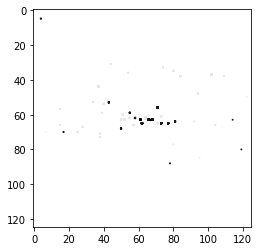

In [19]:
import cupy as cp
record_batch = pf.iter_batches(batch_size=256)

for batch in record_batch:
    
    df = batch.to_pandas()
    xj = df.columns.get_loc('X_jet')
    im = cp.array(np.array(np.array(df.iloc[:, xj].tolist()).tolist()).tolist())
    #plt.imshow(im[0:,0,:,:].get(), cmap='Greys', vmin=0., vmax=1., alpha=0.9)
    plt.imshow(im[0,0,:,:].get(), cmap='Greys', vmin=0., vmax=1., alpha=0.9)
    plt.imshow(im[1,0,:,:].get(), cmap='Greys', vmin=0., vmax=1., alpha=0.9)
    print(im.shape)
    break

In [ ]:
class ParquetDataset(Dataset):
    def __init__(self, filename):
        self.parquet = pq.ParquetFile(filename)
        self.cols = None # read all columns
        #self.cols = ['X_jet.list.item.list.item.list.item','y'] 
    def __getitem__(self, index):
        data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        data['X_CMSII'] = np.float32(data['X_CMSII'][0])
        data['y'] = np.float32(data['y'])
        data['m0'] = np.float32(data['jetM'])
        data['pt'] = np.float32(data['jetPt'])
        # Preprocessing
        data['X_CMSII'][data['X_CMSII'] < 1.e-3] = 0. # Zero-Suppression
        data['X_CMSII'][4,...] = 25.*data['X_CMSII'][4,...] # For HCAL: to match pixel intensity dist of other layers
        data['X_CMSII'] = data['X_CMSII']/100. # To standardize
        return dict(data)
    def __len__(self):
        return self.parquet.num_row_groups

In [ ]:
def custom_div_cmap(numcolors=11, name='custom_div_cmap',mincol='blue', midcol='white', maxcol='red'):
    cmap = LinearSegmentedColormap.from_list(name=name,colors=[mincol, midcol, maxcol],N=numcolors)
    return cmap

pink_map = custom_div_cmap(50, mincol='#FFFFFF', midcol='#F699CD' ,maxcol='#FF1694')

In [ ]:
def plotEvent(img, mins, maxs, str_):
    plt.imshow(np.zeros_like(img[-1,8,:,:]), cmap='Greys', vmin=0., vmax=1., alpha=0.9)
    #if maxs[-1] > 0 : plt.imshow(img[-1,8,:,:], cmap='Greens', norm=LogNorm(), alpha=0.9, vmin=mins[-1], vmax=maxs[-1])
    #if maxs[-2] > 0 : plt.imshow(img[-1,7,:,:], cmap='Purples', norm=LogNorm(), alpha=0.9, vmin=mins[-2], vmax=maxs[-2])
    #if maxs[-3] > 0 : plt.imshow(img[-1,6,:,:], cmap='Blues', norm=LogNorm(), alpha=0.9, vmin=mins[-3], vmax=maxs[-3])
    #if maxs[-4] > 0 : plt.imshow(img[-1,5,:,:], cmap='Greens', norm=LogNorm(), alpha=0.9, vmin=mins[-4], vmax=maxs[-4])
    if maxs[-5] > 0 : plt.imshow(img[-1,4,:,:], cmap='Greys',  norm=LogNorm(), alpha=0.9, vmin=mins[-5], vmax=maxs[-5])
    if maxs[-6] > 0 : plt.imshow(img[-1,3,:,:], cmap='Blues',  norm=LogNorm(), alpha=0.9, vmin=mins[-6], vmax=maxs[-6])
    #if maxs[-7] > 0 : plt.imshow(img[-1,0,:,:], cmap='Oranges',norm=LogNorm(), alpha=0.9, vmin=mins[-7], vmax=maxs[-7])
    #plt.colorbar(fraction=0.046, pad=0.04)

    #X AXIS
    ax = plt.axes()
    plt.xlim([0., 360.+0.])
    #plt.xticks(np.arange(0,360,90))
    plt.xticks(np.arange(0,360,45))
    ax_range_x = np.arange(0,360+45,45)
    ax.set_xticks(ax_range_x)
    ax.set_xticklabels(ax_range_x)
    plt.xlabel(r"$\mathrm{i\varphi}'$", size=28) #28, 30
    ax.xaxis.set_tick_params(direction='in', which='major', length=6.)
    ax.xaxis.set_tick_params(direction='in', which='minor', length=3.)

    #Y AXIS
    #plt.ylim([0., 280.+0.])
    plt.ylim([280+0, 0.])
    #plt.yticks(np.arange(0,280,112))
    #plt.yticks(np.arange(0,280,56))
    plt.yticks(np.arange(280,0,56))
    plt.ylabel(r"$\mathrm{i\eta}'$", size=28) #28, 30
    ax_range_y = np.arange(0,280+56,56)
    ax.set_yticks(ax_range_y)
    ax.set_yticklabels(ax_range_y)
    ax.yaxis.set_tick_params(direction='in', which='major', length=6.)
    ax.yaxis.set_tick_params(direction='in', which='minor', length=3.)

    #LEGEND
    #colors = {1:'tab:orange',2:'tab:blue',3:'tab:grey',4:'tab:green',5:'tab:blue',6:'tab:purple',7:'tab:green'}
    colors = {1:'orange',2:'lightblue',3:'grey',4:'green',5:'blue',6:'purple'}
    #labels = {1:'Track pT',2:'ECAL',3:'HCAL',4:'PXB1',5:'PXB2',6:'PXB3',7:'PXB4'}
    labels = {1:'Track pT',2:'ECAL',3:'HCAL',4:'BPix L1',5:'BPix L2',6:'BPix L3'}
    patches =[mpatches.Patch(color=colors[i],label=labels[i]) for i in colors]
    #plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    plt.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5))

    #plt.legend(handles=patches, loc='best')
    #plt.savefig(str_, bbox_inches='tight')
    plt.savefig(str_, bbox_inches='tight', format='png')
    #plt.show()
    plt.clf()

In [ ]:
import torch
dset_train = ParquetDataset(fileStr)
train_cut = 50
idxs = np.random.permutation(len(dset_train))
train_sampler = sampler.SubsetRandomSampler(idxs[:train_cut])
#train_loader = DataLoader(dataset=dset_train, batch_size=32, num_workers=0, sampler=train_sampler, pin_memory=True)
train_loader = DataLoader(dataset=dset_train, batch_size=2, num_workers=0, shuffle=False, pin_memory=True)
for i, data in enumerate(train_loader):
    #if i == args.nEvents: break
    print ("Event ", i)
    print("jetM:", data['jetM'], " pt:" , data['jetPt'])
    for ele,ele2 in zip(data['ieta'], data['iphi']):
        print("ieta:iphi", torch.mul(ele,5), torch.mul(ele2,5))
    #for ele2 in data['iphi']:
    #    print("iphi:", torch.mul(ele2,5))
    #print("jetM:", data['jetM'], " pt:" , data['jetPt'], " iEta:", torch.mul(data['ieta'],5), 
    #      " iphi:", torch.mul(data['iphi'],5))
    X_train = data['X_CMSII']

    plt.rcParams["font.family"] = "Helvetica"
    plt.rcParams["figure.figsize"] = (24,12)
    plt.rcParams.update({'font.size': 26})
    
    cmap = ['Oranges','Blues','Greys','Reds',pink_map,'Purples','Greens',]
    min_ = 0.0001

    img = X_train[...]

    mins = [0.0001]*7
    maxs = [X_train[-1,0,:,:].max(), X_train[-1,3,:,:].max(), X_train[-1,4,:,:].max(), X_train[-1,5,:,:].max(), X_train[-1,6,:,:].max(), X_train[-1,7,:,:].max(), X_train[-1,8,:,:].max()]
    plotEvent(img, mins, maxs, '%s/event_images/tau_event%d.png'%(outDir,i))